In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

In [67]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
from imblearn.over_sampling import SMOTE

from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

In [68]:
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier

In [69]:
%matplotlib inline
warnings.filterwarnings("ignore", category=RuntimeWarning)
os.chdir(r'C:\Users\신상훈\바탕화면\학과\대학원 1-2\통계적 기계학습\머신러닝')

In [70]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [71]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [72]:
df['heart_disease'].unique()

array([1, 0], dtype=int64)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [7]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [17]:
# A really fantsatic and intelligent way to deal with blanks, from Thoman Konstantin in: https://www.kaggle.com/thomaskonstantin/analyzing-and-modeling-stroke-data

DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

In [18]:
print('Missing values: ',sum(df.isnull().sum()))

Missing values:  0


In [19]:
df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)
df['work_type'] = df['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   uint8  
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   uint8  
 7   Residence_type     5110 non-null   uint8  
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(2), uint8(3)
memory usage: 374.4+ KB


In [26]:
X  = df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']]
y = df['stroke']

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   uint8  
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   work_type          5110 non-null   uint8  
 5   avg_glucose_level  5110 non-null   float64
 6   bmi                5110 non-null   float64
dtypes: float64(3), int64(2), uint8(2)
memory usage: 209.7 KB


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)

In [31]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [32]:
oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())

In [34]:
X_train_resh.shape

(2914, 7)

In [36]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [37]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

## 모델 생성

## RF

In [39]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100,500, 1000],
    'max_depth' : [2,4,6], 
    'min_samples_leaf' : [2,4,6,8 ],
    'min_samples_split' : [2,4,6,8]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
최고 예측 정확도: 0.9504


In [56]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[200,300],
    'max_depth' : [10,12,14,16], 
    'min_samples_leaf' : [2],
    'min_samples_split' : [6]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=4, n_jobs=-1 )
grid_cv.fit(X_train_resh , y_train_resh)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 200}
최고 예측 정확도: 0.9242


In [61]:
best_rf = grid_cv.best_estimator_
best_rf.fit(X_train_resh,y_train_resh)
best_pred = best_rf.predict(X_test)
get_model_train_eval(best_rf, ftr_train=X_train_resh, ftr_test=X_test, tgt_train=y_train_resh, tgt_test=y_test)


오차 행렬
[[3080  324]
 [ 128   45]]
정확도: 0.8736, 정밀도: 0.1220, 재현율: 0.2601,    F1: 0.1661, AUC:0.7801


In [42]:
rf_clf_best = RandomForestClassifier(n_estimators = 100, max_depth = 2, min_samples_leaf = 2, min_samples_split = 2, n_jobs = -1)
get_model_train_eval(rf_clf_best, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


오차 행렬
[[3404    0]
 [ 173    0]]
정확도: 0.9516, 정밀도: 0.0000, 재현율: 0.0000,    F1: 0.0000, AUC:0.8365


C:\Users\신상훈\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
rf_clf_best = RandomForestClassifier(n_estimators = 200, max_depth = 14, min_samples_leaf = 2, min_samples_split = 6, n_jobs = -1,random_state=0)

get_model_train_eval(rf_clf_best, ftr_train=X_train_resh, ftr_test=X_test, tgt_train=y_train_resh, tgt_test=y_test)


오차 행렬
[[3070  334]
 [ 126   47]]
정확도: 0.8714, 정밀도: 0.1234, 재현율: 0.2717,    F1: 0.1697, AUC:0.7781


In [65]:
ftr_top.index

Index(['age', 'bmi', 'avg_glucose_level', 'work_type', 'gender',
       'hypertension', 'heart_disease'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}>

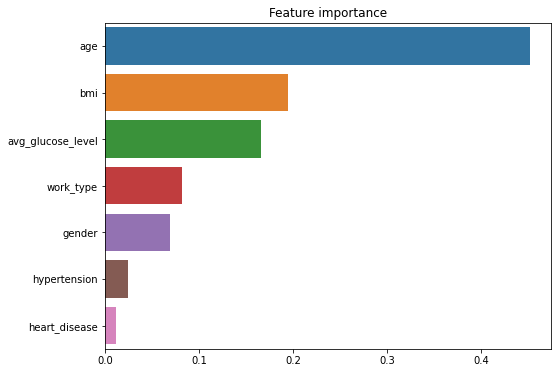

In [58]:
ftr_importance_values = best_rf.feature_importances_
ftr_importance = pd.Series(ftr_importance_values, index = X_train.columns)
ftr_top = ftr_importance.sort_values(ascending = False)

plt.figure(figsize = (8,6))
plt.title('Feature importance')
sns.barplot(x = ftr_top, y = ftr_top.index)

## LGBM

In [59]:
params = {
    'n_estimators':[1000],
    'max_depth' : [6,8,10], 
    'num_leaves' : [33],
    'min_samples_split' : [1,2]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
lgbm_clf = LGBMClassifier(random_state=0, n_jobs=-1)
grid_lgbm = GridSearchCV(lgbm_clf , param_grid=params , cv=5, n_jobs=-1 )
grid_lgbm.fit(X_train_resh , y_train_resh)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

[LightGBM] [Warning] Unknown parameter: min_samples_split
최적 하이퍼 파라미터:
 {'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 200}
최고 예측 정확도: 0.9242


In [55]:
lgbm_clf_best = LGBMClassifier(n_estimators = 1000, max_depth = 6, num_leaves = 33, min_samples_split = 6, n_jobs = -1,random_state=0)

get_model_train_eval(lgbm_clf_best, ftr_train=X_train_resh, ftr_test=X_test, tgt_train=y_train_resh, tgt_test=y_test)


오차 행렬
[[3210  194]
 [ 142   31]]
정확도: 0.9061, 정밀도: 0.1378, 재현율: 0.1792,    F1: 0.1558, AUC:0.7433


In [63]:
best_lgbm = grid_lgbm.best_estimator_
best_lgbm.fit(X_train_resh,y_train_resh)
best_pred = best_lgbm.predict(X_test)
get_model_train_eval(best_lgbm, ftr_train=X_train_resh, ftr_test=X_test, tgt_train=y_train_resh, tgt_test=y_test)


오차 행렬
[[3210  194]
 [ 142   31]]
정확도: 0.9061, 정밀도: 0.1378, 재현율: 0.1792,    F1: 0.1558, AUC:0.7433


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

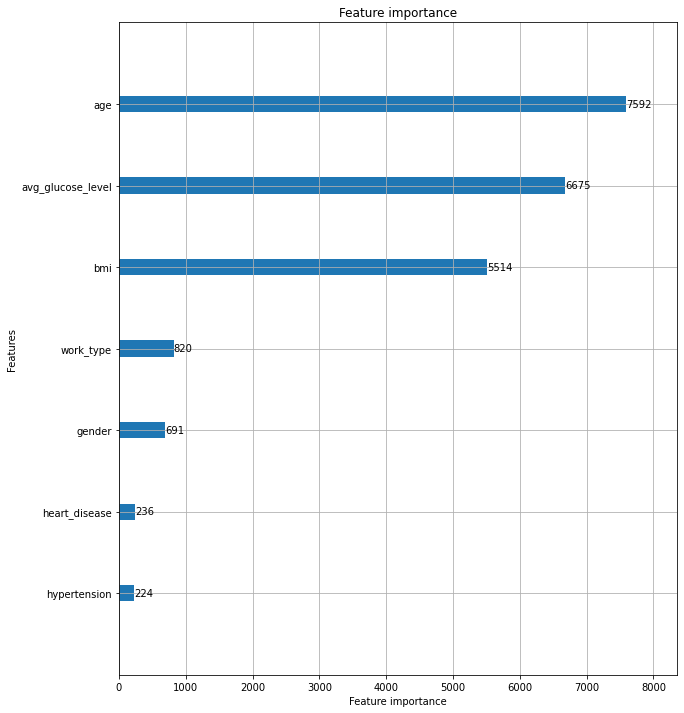

In [64]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(best_lgbm, ax=ax)